In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import glob
import scipy.integrate as integrate
import time
%matplotlib inline

### Significantly still in progress...

(lots of places left to optimize!)

In [2]:
df1 = pd.read_csv('./output/tio2/tio2_0.100um_efficiencies.dat', delimiter='\t')
df2 = pd.read_csv('./output/tio2/tio2_0.951um_efficiencies.dat', delimiter='\t')
df3 = pd.read_csv('./output/tio2/tio2_0.500um_efficiencies.dat', delimiter='\t')
df4 = pd.read_csv('./output/tio2/tio2_0.250um_efficiencies.dat', delimiter='\t')

dfs = [df1, df2, df3, df4]

all_dats = glob.glob('./output/tio2/*dat')
test_dats = all_dats[:50]

In [3]:
def concat_lxmiedats(datafiles):
    '''
    inputs: list of LX-MIE output data files, i.e., list of datafile names
    
    returns:
        wavelengths_um = all of the wavelengths of the mie scattering calculations, in microns
        qext_df = dataframe with extinction coefficients, indexed over the wavelengths, one column for each grain size
        grains = all of the grain sizes used in the mie calculations
        
    note: this is a bit clunky and slow, but it works and only needs to be run once; revisit later.
    '''
    
    new_dfs = []
    grains = []

    for idx, datfile in enumerate(datafiles):
        # read in datafile
        df = pd.read_csv(datfile, delimiter='\t')

        # drop columns we're not using
        new_df = df[['#wavelengths (mu)','q_ext           ']]

        # grab the grain size from the filename
        grainsize = datfile.split('_')[1]
        new_df.rename(columns={'#wavelengths (mu)':'wv_um', 'q_ext           ':'q_ext_' + grainsize}, inplace=True)
        grains.append(grainsize.strip('um'))

        # just append the new df into the mega list:
        new_dfs.append(new_df)
        
    # merge all of the dataframes into a single dataframe, based on wavelength column index
    qext_df = reduce(lambda left, right: pd.merge(left, right, on="wv_um"), new_dfs)
    
    # save wavelength array to be used later:
    wavelengths_um = np.array(qext_df['wv_um'])
    
    # transpose the combined dataframe to return an array of Qext values, one for each grain size, per wavelength
    # there is certainly a more clever way involving creation of a three-dimensional array....
#     combo_df.set_index('wv_um', inplace=True)
#     df_transpose = combo_df.T
    
    # the way to retrieve list of Qext for many grains at a given wavelength, operating on rows: 
    # np.array(qext_df.iloc[idx])[1:] returns a row, where index matches the index of the wavelength of interest 
    # NB (1: drops first element in array, which is just the wavelength value)
    
    grains = np.array([float(x) for x in grains])
    
    return wavelengths_um, qext_df, grains
    

In [4]:
wv, qext_df, grains = concat_lxmiedats(all_dats)

/Users/kwardduong/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


## Try out the integral now!

Q_ext as a function of wavelength is written as follows, integrated over a given particle distribution:
    
$Q_{ext}(\lambda) = \frac{\int_{r_{min}}^{r_{max}}\pi r^{2} Q_{ext}(r, \lambda) n(r) dr}{\int_{r_{min}}^{r_{max}} \pi r^{2} n(r) dr}$    

So we can try to numerically integrate this, based on the output from LX-MIE.

In [5]:
# Define some useful functions first

def n(r):
    """
    Grain size distribution.
    Update this with the relevant grain distribution of your choice.
    """
    return r**-3


def get_qext(wavelength, wv, qext_df):
    """
    a little function to return Q_ext(r) for a fixed wavelength from the above dataframe.
    said fixed wavelength MUST be the same quantity in the wavelength array, so slice carefully.
    this is what goes into the lambda notation below (q_returned)
    """
    idx = np.where(wv == wavelength)[0][0]
    qext_wv = np.array(qext_df.iloc[idx])[1:]
    return qext_wv



# lambda notation!
top_integrand = lambda r, q_returned: np.pi * (r**2) * q_returned * n(r)

bottom_integrand = lambda r: np.pi * (r**2) * n(r)


In [13]:
# IMPROVED "vectorized" approach. (This is literally 1000x faster...)
    
# first, let's make the wavelength range something more reasonable.
min_wv = 0.5 
max_wv = 5.0

# wv_short = wv[0::25] # start : stop : step -- uncomment for testing purposes and replace wv below w/wv_short

wv_restricted = wv[(wv > min_wv) & (wv < max_wv)]

t0 = time.time()

# the following list should be Q_ext(wv) for each wavelength, integrated over particle size
qvals = []

for ii in range(0, len(wv)):
    if wv[ii] > min_wv and wv[ii] < max_wv:
        q = get_qext(wv[ii], wv, qext_df)
        qext = integrate.simps(top_integrand(grains, q), grains) / integrate.simps(bottom_integrand(grains), grains)
        qvals.append(qext)
    
t1 = time.time()

print("time to complete " + str(len(wv)) + " calculations: " + str(np.round(t1-t0,3)) + " seconds")

time to complete 7344 calculations: 4.382 seconds


In [7]:
np.savetxt('qext_calc_revised.txt', np.c_[wv_restricted, qvals])

In [8]:
wv_restricted_old, qvals_old = np.loadtxt('qext_calc.txt').T

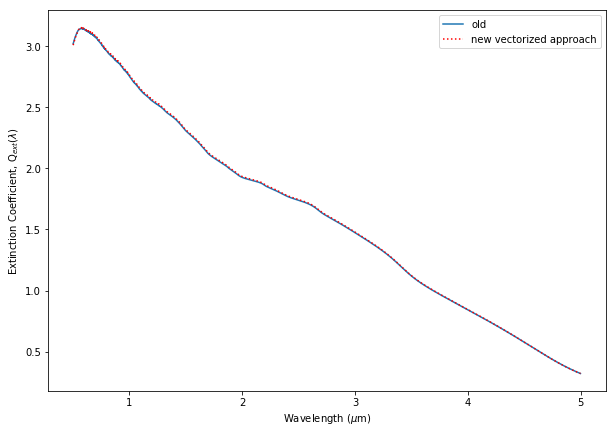

In [11]:
plt.figure(figsize=(10,7))
plt.plot(wv_restricted_old, qvals_old, label='old')
plt.plot(wv_restricted, qvals, 'r:', label='new vectorized approach')
plt.legend(loc=1)
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'Extinction Coefficient, Q$_{ext}(\lambda)$')
# plt.xlim(0.5,0.75)
# plt.ylim(2.95,3.2)